# 0.0 Imports

In [3]:
import pandas             as pd
import numpy              as np
#import xgboost            as xgb
import scikitplot         as skplt

import matplotlib.pyplot  as plt
import seaborn            as sns

from IPython.display         import Image
from scipy                   import stats            as ss
from sklearn                 import preprocessing    as pp
from sklearn                 import model_selection  as ms
from sklearn                 import ensemble         as en
from sklearn                 import metrics          as m
from scikitplot              import metrics          as mt
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble     import RandomForestClassifier
#from boruta               import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
#from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
#from skopt                import forest_minimize
#from skopt.plots          import plot_convergence
from flask                import Flask, request, Response

import warnings
import pickle
import inflection
warnings.filterwarnings("ignore")

%matplotlib inline

## 0.1 Helper Functions

## 0.2 Loading Data

In [4]:
data_kaggle = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_kaggle_block_fraud_company.csv')

In [5]:
data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
data_kaggle['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

- Memory usage is too high (500MB+), there are many data to manipulate in a local machine. A split strategy will be applied to split data for less memory use

### 0.2.1 Data split 

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_1_index, train_2_index in split.split(data_kaggle, data_kaggle['isFraud']):
    strat_train_1_set = data_kaggle.loc[train_1_index]
    strat_train_2_set = data_kaggle.loc[train_2_index]

In [15]:
strat_train_2_set.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv', index=False)
strat_train_2_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272524 entries, 4051353 to 2496743
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1272524 non-null  int64  
 1   type            1272524 non-null  object 
 2   amount          1272524 non-null  float64
 3   nameOrig        1272524 non-null  object 
 4   oldbalanceOrg   1272524 non-null  float64
 5   newbalanceOrig  1272524 non-null  float64
 6   nameDest        1272524 non-null  object 
 7   oldbalanceDest  1272524 non-null  float64
 8   newbalanceDest  1272524 non-null  float64
 9   isFraud         1272524 non-null  int64  
 10  isFlaggedFraud  1272524 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 116.5+ MB


- Now memory is 116 MB of usage, more acceptable to use in a local machine to manipulate data and process it.

### 0.2.1 Loading splited data

In [35]:
data_splited = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv')

#### 0.2.1.1 Slipt data in dataset (train and validation) and test

In [36]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test_1_index, test_2_index in split.split(data_splited, data_splited['isFraud']):
    dataset = data_splited.loc[test_1_index]
    dataset_test = data_splited.loc[test_2_index]

In [37]:
dataset['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [38]:
dataset_test['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

# 1.0 Data Description

In [39]:
df1 = dataset.copy()

## 1.1 Rename Columns

In [40]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [41]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [42]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

# 1.2 Data Dimension

In [43]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 5090096
Number of Columns: 11


## 1.3 Data Types

In [44]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

- It is not necessary to change data types.

## 1.4 Check NAN

In [45]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

- There is no NAN in original datas

## 1.5 Fillout NA

- Not necessary, as seen in 1.4 section

## 1.6 Columns Description

In [46]:
cols = df1.columns
cols

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

- **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


- **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


- **amount**: amount of the transaction in local currency.


- **nameOrig**: customer who started the transaction


- **oldbalanceOrg**: initial balance before the transaction


- **newbalanceOrig**: new balance after the transaction


- **nameDest**: customer who is the recipient of the transaction


- **oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).


- **newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).


- **isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.


- **isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1.7 Descriptive Statistical

In [47]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

In [48]:
num_attributes = df1[['step', 'amount', 'oldbalance_org', 'newbalance_orig','oldbalance_dest','newbalance_dest']]

cat_attributes = df1[['type', 'name_orig', 'name_dest', 'is_flagged_fraud' ]]

target_atribute = df1['is_fraud']

### 1.7.1 Numerical Attributes

In [49]:
# Central Tendency - Mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate

m1 = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.433626e+02,239.000,1.423198e+02,0.375190,0.328697
1,amount,0.0,9.244552e+07,9.244552e+07,1.799096e+05,74841.030,6.024578e+05,30.513042,1736.803090
2,oldbalance_org,0.0,5.958504e+07,5.958504e+07,8.337449e+05,14212.000,2.887601e+06,5.248940,32.977270
3,newbalance_orig,0.0,4.958504e+07,4.958504e+07,8.549461e+05,0.000,2.923386e+06,5.176258,32.066187
4,oldbalance_dest,0.0,3.560159e+08,3.560159e+08,1.100383e+06,132801.065,3.403514e+06,20.112960,964.983526
5,newbalance_dest,0.0,3.561793e+08,3.561793e+08,1.224793e+06,215013.220,3.676909e+06,19.447839,868.921775


### 1.7.2 Categorical Attributes

In [50]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type                      5
name_orig           5084156
name_dest           2266013
is_flagged_fraud          2
dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

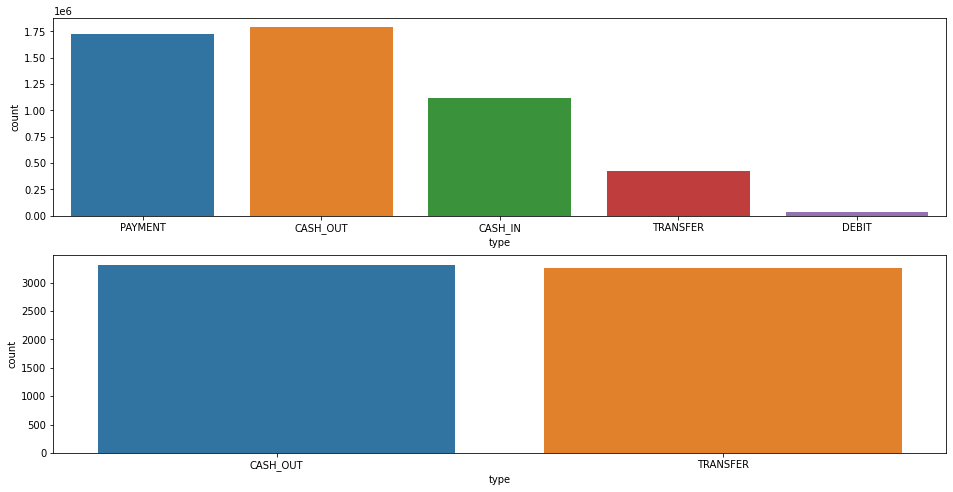

In [51]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))

sns.countplot(x ='type', data= df1[df1['is_fraud']==0], ax=axs[0])

sns.countplot(x ='type', data= df1[df1['is_fraud']==1], ax=axs[1])

In [57]:
df1[df1['is_fraud']==1]['name_orig'].value_counts()

C659082738     1
C1797578392    1
C1032891419    1
C46140680      1
C99129129      1
              ..
C1468373827    1
C362205540     1
C1790329459    1
C22591109      1
C75004200      1
Name: name_orig, Length: 6570, dtype: int64

<AxesSubplot:xlabel='name_orig', ylabel='Density'>

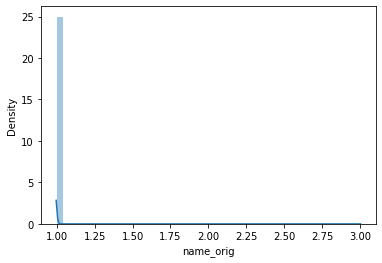

In [55]:
sns.distplot(cat_attributes['name_orig'].value_counts())

In [58]:
df1[df1['is_fraud']==1]['name_dest'].value_counts()

C643624257    2
C104038589    2
C410033330    2
C385133759    2
C967226405    2
             ..
C112266797    1
C371379583    1
C832749526    1
C16371707     1
C107263754    1
Name: name_dest, Length: 6541, dtype: int64

<AxesSubplot:xlabel='name_dest'>

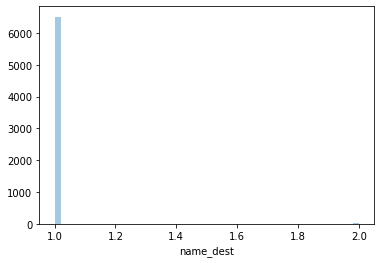

In [63]:
sns.distplot(df1[df1['is_fraud']==1]['name_dest'].value_counts(), kde = False)

In [62]:
target_atribute.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: is_fraud, dtype: float64

**Data Description Summary:**

1. **XXX** 
    - Range is from 20 to 85. 
    - Mean is 38.82 and median is 36. 
    - Higher density is from 20 to 29 with 42%, followed by 40 to 49 with 19,9%.
****    


## 1.8 Save dataset

In [ ]:
df1.to_csv('df1.csv', index=False)

# 2.0 Feature Engineering And Variables Filtering

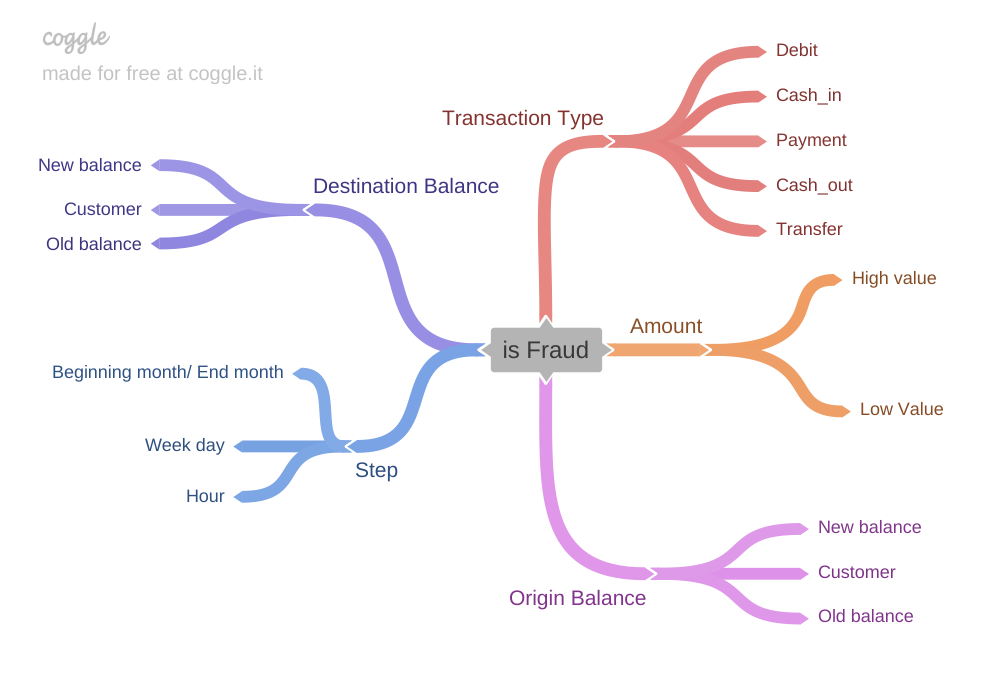

In [74]:
Image ('C:/Users/Guilherme/Repos/pa002_block_fraud_company/images/is_Fraud.png')

## 2.1 Hypotheses creation

### 2.1.1 Amount Hypotheses

 **1.** Fraud should occur in higher value amounts (higher than 100k)
 
 **2.** Fraud should occur in higher percent amount per origin balance (higher than 75%)
 
****

### 2.1.2 Transaction Type Hypotheses

 **1.** Fraud should occur in payment type of transaction
 
 **2.** Fraud should not occur in debit type of transaction
 
****

### 2.1.3 Origin Balance Hypotheses

 **1.** Fraud should occur when the difference between old balance and new balance is lower than amount
 
 **2.** Fraud should not occur when the difference between old balance and new balance is equal to amount
 
 **3.** Fraud should not occur when new balance is equal to 0
 
****

### 2.1.4 Destination Balance Hypotheses

 **1.** Fraud should occur when the difference between new balance and old balance is lower than amount
 
 **2.** Fraud should not occur when the difference between new balance and old balance is equal to amount
 
 **3.** Fraud should not occur when destination is merchant
 
 **4.** Fraud should occur with destination that receive with more frequency
 
****

### 2.1.5 Step Hypotheses

 **1.** Fraud should occur in the beginning of the month (day 1 to day 8)
 
 **2.** Fraud should occurs in weekends
 
 **3.** Fraud should occurs during night (6pm to 10pm)
 
****

## 2.2 Creating New Features

In [81]:
df2 = pd.read_csv('df1.csv')

In [88]:
#step features

#hour
df2['hour'] = df2['step'].apply( lambda x: x % 24 )


#day
df2['day'] = df2['step'].apply( lambda x: np.ceil(x / 24) )


#difference between old and new balance origin
df2['diff_orig'] = df2['oldbalance_org'] - df2['newbalance_orig']

#difference between new and old balance destination
df2['diff_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

#merchant destination flag
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

## 2.3 Variable Filtering

<AxesSubplot:xlabel='newbalance_dest'>

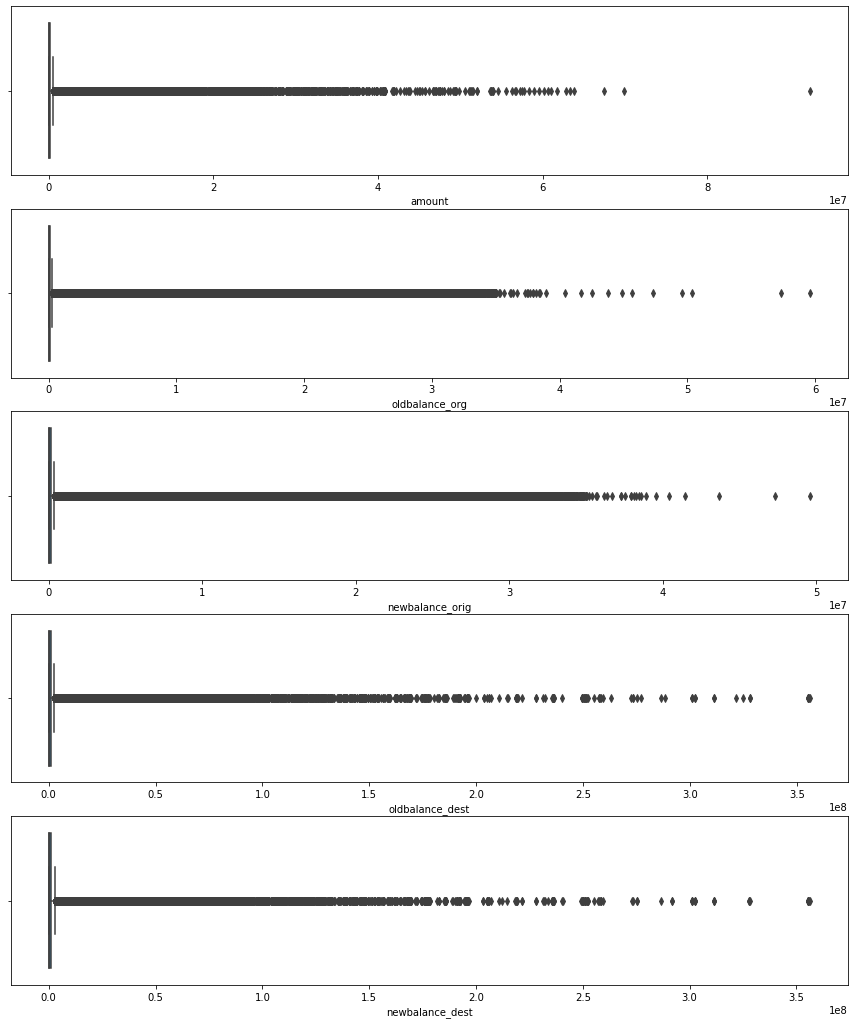

In [100]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

In [101]:
df2 = df2[df2['amount'] < 4e7]
df2 = df2[df2['oldbalance_org'] < 4e7]
df2 = df2[df2['newbalance_orig'] < 4e7]
df2 = df2[df2['oldbalance_dest'] < 2e8]
df2 = df2[df2['newbalance_dest'] < 2e8]

<AxesSubplot:xlabel='newbalance_dest'>

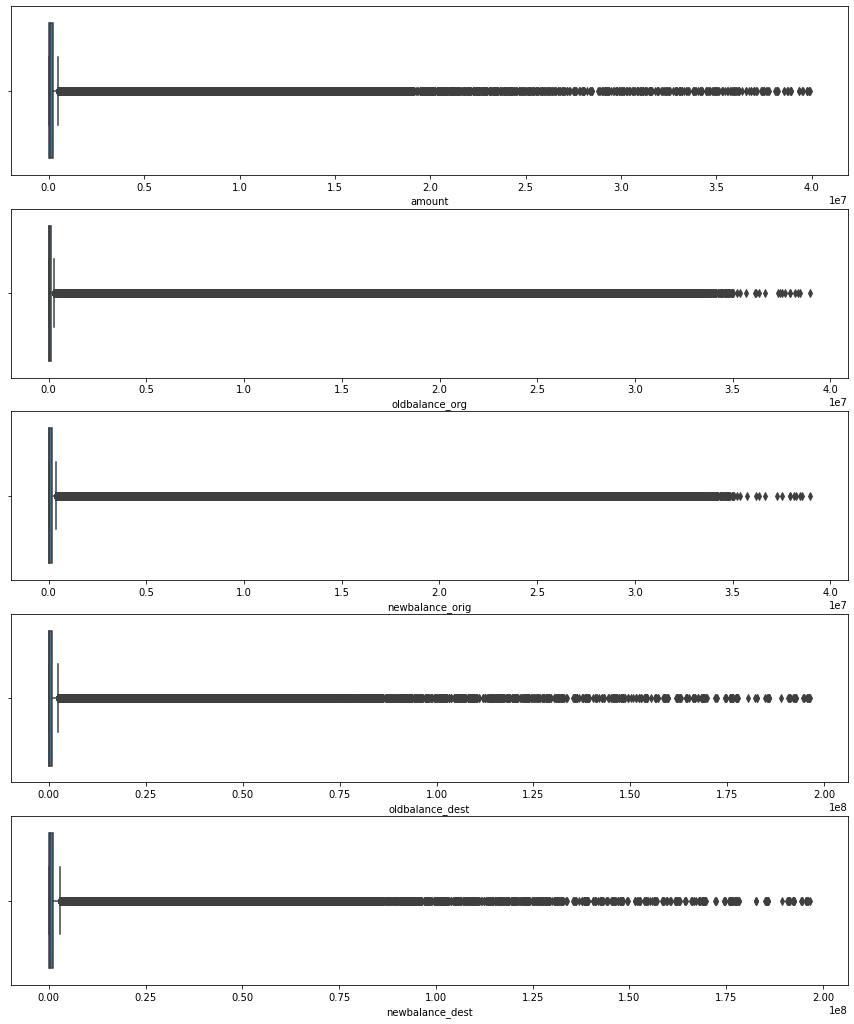

In [102]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

## 2.4 Save dataset

In [103]:
df2.to_csv('df2.csv', index=False)

# 3.0 Exploratory Data Analysis (EDA)

In [104]:
df3 = pd.read_csv('df2.csv')

## 3.1 Univariate Analysis

In [ ]:
df3.columns

### 3.1.1 Numerical variables

#### 3.1.1.1 Step analysis

#### 3.1.1.2 Day analysis

#### 3.1.1.3 Hour analysis

#### 3.1.1.4 Amount analysis

#### 3.1.1.5 Old balance origin analysis

#### 3.1.1.6 New balance origin analysis

#### 3.1.1.7 Difference balance origin analysis

#### 3.1.1.8 Old balance destination analysis

#### 3.1.1.9 New balance destination analysis

#### 3.1.1.10 Difference balance destination analysis

### 3.1.2 Categorical variables

#### 3.1.2.1 Transaction type analysis

#### 3.1.2.2 Name origin analysis

#### 3.1.2.3 Name destination analysis

#### 3.1.2.4 Is flagged fraud analysis

#### 3.1.2.5 Merchant destination analysis

### 3.1.3 Target variable

In [ ]:
df2['hour_sen'] = df2['step'].apply( lambda x: np.sin( x%24 * (2. * np.pi/24 ) ) )
df2['hour_cos'] = df2['step'].apply( lambda x: np.cos( x%24 * (2. * np.pi/24 ) ) )

df2['day_sen'] = df2['step'].apply( lambda x: np.sin( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )
df2['day_cos'] = df2['step'].apply( lambda x: np.cos( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )